尝试自己实现一个简单的神经网络

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# 定义一个曲线
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
sub_x = np.linspace(-10,10)
sub_x

array([-10.        ,  -9.59183673,  -9.18367347,  -8.7755102 ,
        -8.36734694,  -7.95918367,  -7.55102041,  -7.14285714,
        -6.73469388,  -6.32653061,  -5.91836735,  -5.51020408,
        -5.10204082,  -4.69387755,  -4.28571429,  -3.87755102,
        -3.46938776,  -3.06122449,  -2.65306122,  -2.24489796,
        -1.83673469,  -1.42857143,  -1.02040816,  -0.6122449 ,
        -0.20408163,   0.20408163,   0.6122449 ,   1.02040816,
         1.42857143,   1.83673469,   2.24489796,   2.65306122,
         3.06122449,   3.46938776,   3.87755102,   4.28571429,
         4.69387755,   5.10204082,   5.51020408,   5.91836735,
         6.32653061,   6.73469388,   7.14285714,   7.55102041,
         7.95918367,   8.36734694,   8.7755102 ,   9.18367347,
         9.59183673,  10.        ])

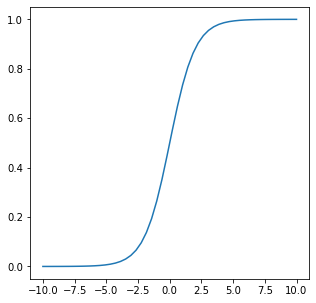

In [4]:
fig = plt.figure(figsize=(5,5))
plt.plot(sub_x,sigmoid(sub_x))

In [5]:
# 定义一个直线
def random_linear(x):
    k,b = random.normalvariate(0,1),random.normalvariate(0,1)

    return x * k + b

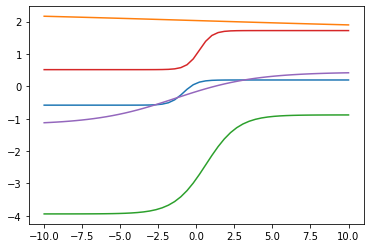

In [6]:
# 当直线和曲线组成复合函数的时候就能拟合出更加复杂的曲线，从而解决实际中的更加负责的问题
for _ in range(5):
    plt.plot(sub_x,random_linear(sigmoid(random_linear(sub_x))))

In [7]:
from matplotlib.animation import FuncAnimation

In [8]:
%matplotlib notebook

In [9]:
def draw_a_random_curve():
    i = random.choice(range(len(sub_x)))
    linear_output = np.concatenate((random_linear(sub_x[:i]), random_linear(sub_x[i:])))
    i2 = random.choice(range(len(linear_output)))
    output = np.concatenate((random_linear(sigmoid(linear_output[:i2])), random_linear(sigmoid(linear_output[i2:]))))
    
    return output

def draw(index):
    fig.clear()
    plt.plot(sub_x, draw_a_random_curve(), color='green')
    plt.plot(sub_x, draw_a_random_curve(), color='red')

fig = plt.gcf()
FuncAnimation(fig, draw, interval=500)

<IPython.core.display.Javascript object>

In [10]:
%matplotlib inline

## 我们可以使用上边的两个简单函数定义一个复杂的model

def model(x,k1,b1,k2,b2):
    #line1
    line_out_1 = x * k1 + b1
    #sigmoid1
    sigmoid_out_2 = sigmoid(line_out_1)
    #line2
    line_out_2 = sigmoid_out_2 * k2 + b2
    return out

 ## 根据以上model我们训练时更新参数就应该采用以下的形式
    k1 = k1 + (-1) * loss对k1的偏导
    b1 = b1 + (-1) * loss对b1的偏导
    k2 = k2 + (-1) * loss对k1的偏导
    b2 = b2 + (-1) * loss对b1的偏导
 ## 问如何求 loss 对各个参数的偏导呢？？
## 可以先找出函数之间和各参数之间的关系，然后通过链接关系逐一求导

## 现在我们用一个图表示以上模型的各个参数 与 函数 和 loss 之间的关系

In [11]:
computing_graph={
    'k':['linear'],
    'b':['linear'],
    'x':['linear'],
    'linear':['sigmoid'],
    'sigmoid':['loss'],
    'y':['loss']
}

In [12]:
import networkx as nx

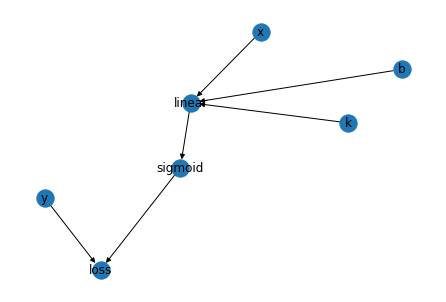

In [13]:
nx.draw(nx.DiGraph(computing_graph),with_labels=True)

In [14]:
# 根据关系树，我们可以写一个程序 --- 通过输入一个节点找到这个节点的输出节点

def get_output(graph,node):
    outputs = []
    for n, out_node in graph.items():
        if node == n:
            outputs += out_node
    return outputs

In [15]:
get_output(computing_graph,"k")

['linear']

### 问，如何获得k1的偏导
+ 获得k1的输出节点
+ 获得k1输出节点的输出节点
+ .. 直到我们找到了最后的一个节点
+ 然后从最后一个节点按照我们找到的关系一步步求解偏导

In [16]:
def get_parameter_partial_order(graph,p):

    computing_order = []

    target = p
    out = get_output(graph, target)[0]
    computing_order.append(target)

    while out:
        computing_order.append(out)
        out = get_output(graph, out)
        if out: out = out[0]

    order = []

    for index, n in enumerate(computing_order[:-1]):
        order.append((computing_order[index+1], n))

    return ' * '.join(['∂{}/∂{}'.format(a, b) for a, b in order[::-1]])

In [17]:
for p in ['k','b']:
    print(get_parameter_partial_order(computing_graph,p))

∂loss/∂sigmoid * ∂sigmoid/∂linear * ∂linear/∂k
∂loss/∂sigmoid * ∂sigmoid/∂linear * ∂linear/∂b


## 以上的计算顺序是通过拓扑排序获取的，接下来我们来实现拓扑排序

In [18]:
simple_graph = {
    'a': [1, 2],
    'b': [2, 3]
}

In [19]:
list(simple_graph.keys())

['a', 'b']

In [20]:
from functools import reduce

In [21]:
reduce(lambda x, y: x+y, list(simple_graph.values()))

[1, 2, 2, 3]

In [22]:
def topologic(graph):
    sorted_node = []
    
    while graph:
        all_nodes_have_inputs = reduce(lambda x, y: x+y,list(graph.values()))
        all_nodes_have_outputs = list(graph.keys())
        
        all_nodes_only_have_outputs_no_inputs = set(all_nodes_have_outputs)-set(all_nodes_have_inputs)
        
        if all_nodes_only_have_outputs_no_inputs:
            node = random.choice(list(all_nodes_only_have_outputs_no_inputs))
            sorted_node.append(node)
            if len(graph) == 1: sorted_node += graph[node]
                
            graph.pop(node)
        
        else:
            raise TypeError('this graph has circle,which cannot get topological order!')
    return sorted_node

In [23]:
computing_graph={
    'k':['linear'],
    'b':['linear'],
    'x':['linear'],
    'linear':['sigmoid'],
    'sigmoid':['loss'],
    'y':['loss']
}
print(topologic(computing_graph))

['x', 'y', 'b', 'k', 'linear', 'sigmoid', 'loss']


$$\partial$$

In [24]:
class Node:
    def __init__(self, inputs=[],name=None,is_trainable=False):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.value = None
        self.gradients = dict()
        self.is_trainable = is_trainable
        
        for node in inputs:
            node.outputs.append(self)
            
    def __repr__(self):
        return 'Node: {}'.format(self.name)
    
    def forward(self):
        print('i am {} my value is {}, i have no human baba,i calculate myself value by MYSELF!'.format(self.name,self.vale))
        
    def backward(self):
        for node in self.inputs:
            print('get ∂{}/∂{}'.format(self.name,node.name))

In [25]:
class Placeholder(Node):
    def __init__(self, name=None,is_trainable=False): 
        Node.__init__(self, name=name,is_trainable=is_trainable)
        
    def __repr__(self):
        return 'Placeholder: {}'.format(self.name)
    
    
    def forward(self):
        pass
#         self.value = self.value
#         print('i am {},my value is {}, i was assigned by human baba!'.format(self.name,self.value))
        
    def backward(self):
        self.gradients[self] = self.outputs[0].gradients[self]
#         print('i am the gradient of Placeholder {}: {}'.format(self.name,self.gradients[self]))

        
        
class Linear(Node):
    def __init__(self, x, k, b, name=None):
        Node.__init__(self, inputs=[x, k, b], name=name)
        
    def __repr__(self):
        return 'Linear: {}'.format(self.name)
    
    def forward(self):
        x, k, b = self.inputs[0], self.inputs[1], self.inputs[2]
        self.value = k.value * x.value + b.value
#         print('i am {} my value is {}, i have no human baba,i calculate myself value by MYSELF!'.format(self.name,self.value))

    def backward(self):
#         self.gradients[self.inputs[0]] = ' * '.join([self.outputs[0].gradients[self],
#                                                      '∂{}/∂{}'.format(self.name,self.inputs[0].name)])
#         self.gradients[self.inputs[1]] = ' * '.join([self.outputs[0].gradients[self],
#                                                      '∂{}/∂{}'.format(self.name,self.inputs[1].name)])
#         self.gradients[self.inputs[2]] = ' * '.join([self.outputs[0].gradients[self],
#                                                      '∂{}/∂{}'.format(self.name,self.inputs[2].name)])
        x, k, b = self.inputs[0], self.inputs[1], self.inputs[2]
        self.gradients[self.inputs[0]] = self.outputs[0].gradients[self] * k.value
        self.gradients[self.inputs[1]] = self.outputs[0].gradients[self] * x.value
        self.gradients[self.inputs[2]] = self.outputs[0].gradients[self] * 1
                                                     
#         print('i am the gradient of linear first parameter {} : {}'.format(self.inputs[0].name,self.gradients[self.inputs[0]]))
#         print('i am the gradient of linear second parameter {} : {}'.format(self.inputs[1].name,self.gradients[self.inputs[1]]))
#         print('i am the gradient of linear third parameter {} : {}'.format(self.inputs[2].name,self.gradients[self.inputs[2]]))
#         print('k.value:{}, x.value:{}'.format(k.value , x.value))
        
class Sigmoid(Node):
    def __init__(self, x, name=None):
        Node.__init__(self, inputs=[x], name=name)
        
    def __repr__(self):
        return 'Sigmoid: {}'.format(self.name)
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def forward(self):
        x = self.inputs[0]
        self.value = self._sigmoid(x.value)
#         print('i am {} my value is {}, i have no human baba,i calculate myself value by MYSELF!'.format(self.name,self.value))
    
    def backward(self):
#         self.gradients[self.inputs[0]] = ' * '.join([self.outputs[0].gradients[self],
#                                                      '∂{}/∂{}'.format(self.name,self.inputs[0].name)])
        x = self.inputs[0]    
        self.gradients[self.inputs[0]] = self.outputs[0].gradients[self] * (self._sigmoid(x.value) * (1 - self._sigmoid(x.value)))
#         print('i am the gradient of sigmoid first parameter {} : {}'.format(self.inputs[0].name,self.gradients[self.inputs[0]]))
#         print( self._sigmoid(x.value) , (1 - self._sigmoid(x.value)),x.value)
        
class Loss_MSE(Node):
    def __init__(self, y, yhat, name=None):
        Node.__init__(self, inputs=[y, yhat], name=name)
        
    def __repr__(self):
        return 'Loss_MSE: {}'.format(self.name)

    
    def forward(self):
        y, yhat = self.inputs[0], self.inputs[1]
        self.value = np.mean((y.value - yhat.value)**2)
#         print('i am {} my value is {}, i have no human baba,i calculate myself value by MYSELF!'.format(self.name,self.value))
    
    def backward(self):
#         self.gradients[self.inputs[0]] = '∂{}/∂{}'.format(self.name,self.inputs[0].name)
#         self.gradients[self.inputs[1]] = '∂{}/∂{}'.format(self.name,self.inputs[1].name)
        y, yhat = self.inputs[0], self.inputs[1]
        self.gradients[self.inputs[0]] = 2 * np.mean(y.value - yhat.value)
        self.gradients[self.inputs[1]] = -2 * np.mean(y.value - yhat.value)
#         print('i am the gradient of loss first parameter {} : {}'.format(self.inputs[0].name,self.gradients[self.inputs[0]]))
#         print('i am the gradient of loss second parameter {} : {}'.format(self.inputs[1].name,self.gradients[self.inputs[1]]))

In [26]:
node_x = Placeholder(name = 'x')
node_k = Placeholder(name = 'k',is_trainable=True)
node_b = Placeholder(name = 'b',is_trainable=True)
node_linear = Linear(x=node_x, k=node_k, b=node_b, name = 'linear')
node_sigmoid = Sigmoid(x=node_linear,name = 'sigmoid')
node_y = Placeholder(name = 'y')
node_loss = Loss_MSE(yhat=node_sigmoid, y=node_y,name = 'loss')


In [27]:
need_expand_nodes = [node_x,node_k,node_b,node_y]

feed_dict = {
    node_x: 3,
    node_k: random.random(),
    node_b: 0.38,
    node_y: random.random()
}

In [28]:
from collections import defaultdict

In [29]:
def convert_feed_dict_to_graph(feed_graph):
    need_expand_nodes = list(feed_dict.keys())
    computing_graph = defaultdict(list)

    while need_expand_nodes:
        n = need_expand_nodes.pop(0)

        if n in computing_graph:continue

        if isinstance(n,Placeholder): n.value = feed_dict[n]
        
        for m in n.outputs:
            computing_graph[n].append(m)
            need_expand_nodes.append(m)
    return computing_graph

In [30]:
computing_graph = convert_feed_dict_to_graph(feed_dict)
computing_graph 

defaultdict(list,
            {Placeholder: x: [Linear: linear],
             Placeholder: k: [Linear: linear],
             Placeholder: b: [Linear: linear],
             Placeholder: y: [Loss_MSE: loss],
             Linear: linear: [Sigmoid: sigmoid],
             Sigmoid: sigmoid: [Loss_MSE: loss]})

In [31]:
sorted_nodes = topologic(convert_feed_dict_to_graph(feed_dict))

In [32]:
sorted_nodes

[Placeholder: y,
 Placeholder: x,
 Placeholder: k,
 Placeholder: b,
 Linear: linear,
 Sigmoid: sigmoid,
 Loss_MSE: loss]

## 模拟神经网络的计算过程

In [33]:
def forward(sorted_nodes):
    # feedforward
    for node in sorted_nodes:
        node.forward()
        if isinstance(node, Loss_MSE):
            print('Loss value: {}'.format(node.value))

def backward(sorted_nodes):
    # get partial by backward
    for node in sorted_nodes[::-1]: # 按照topoloic 相反的顺序求导
#         print('\ni am {}'.format(node.name))
        node.backward()

def optimize(sorted_nodes,learning_rate):
    # optimize
    for node in sorted_nodes:
        if node.is_trainable:
            node.value = node.value + (-1) * node.gradients[node] * learning_rate
            print('node : {} , value : {}, gradient: {}'.format(node.name,node.value,node.gradients[node]))

In [34]:
epoches = 10000
learning_rate = 1e-2
history_loss = []
for _ in range(epoches):
    forward(sorted_nodes=sorted_nodes)
    backward(sorted_nodes=sorted_nodes)
    
    __loss_node = sorted_nodes[-1]
    assert isinstance(__loss_node,Loss_MSE)
    history_loss.append(__loss_node.value)
    
    optimize(sorted_nodes=sorted_nodes,learning_rate=learning_rate)

Loss value: 0.10923241083541098
node : k , value : 0.5349924172953057, gradient: 0.2095923547911886
node : b , value : 0.3793013588173627, gradient: 0.06986411826372953
Loss value: 0.10874356264081111
node : k , value : 0.5328900701649509, gradient: 0.210234713035468
node : b , value : 0.3786005764405778, gradient: 0.07007823767848934
Loss value: 0.10825171785425665
node : k , value : 0.5307813179627423, gradient: 0.2108752202208673
node : b , value : 0.37789765903984157, gradient: 0.07029174007362243
Loss value: 0.10775687615279594
node : k , value : 0.5286661805044798, gradient: 0.2115137458262517
node : b , value : 0.37719261322042075, gradient: 0.07050458194208391
Loss value: 0.10725903791098164
node : k , value : 0.5265446789382814, gradient: 0.21215015661983933
node : b , value : 0.37648544603168793, gradient: 0.07071671887327978
Loss value: 0.10675820422085894
node : k , value : 0.5244168357718514, gradient: 0.2127843166430018
node : b , value : 0.37577616497621125, gradient: 0.

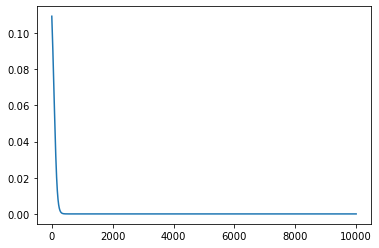

In [35]:
plt.plot(history_loss)

In [36]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [43]:
yhat = sigmoid(sorted_nodes[1].value * sorted_nodes[3].value + sorted_nodes[2].value)

In [44]:
yhat

0.6459338825298628

In [47]:
sorted_nodes[0].value

0.5493736374778408